In [2]:
##Importing libraries
import pandas as pd
import requests
import pickle
import re
import string
import unidecode 
import wordninja
import docx2txt
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from autocorrect import Speller 
from nltk.corpus import stopwords 
from nltk import word_tokenize 
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from alive_progress import alive_bar
pd.set_option("display.max_rows", None, "display.max_columns", None)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.pairwise import cosine_similarity




In [4]:
##Pull the data out
data_clean = pd.DataFrame()
df_resume = pd.DataFrame()
data_clean = pd.read_pickle('clean_data.pkl')
df_resume = pd.read_pickle('df_resume.pkl')

In [5]:
data_clean_stopwords = pd.DataFrame()
data_clean_stopwords = pd.read_pickle('data_clean_stopwords.pkl')


In [6]:
data = pd.read_csv('dice_com-job_us_sample.csv')

In [7]:
resume_ori = docx2txt.process("Sample_CV.docx")

In [8]:
#A deeper cleaning: Stemming
stemmer = SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [9]:
data_clean1 = pd.DataFrame(data_clean.jobdescription.apply(stemm_text))
data_clean1.head()

,jobdescription
0,look for selenium engin must have solid java c...
1,the univers of chicago has a rapid grow secur ...
2,galax solutionseveri day our solut affect peop...
3,java developerful time direct hire bo ling bro...
4,midtown base high tech firm has an immedi need...


In [12]:
df_resume1 = pd.DataFrame(df_resume.resume.apply(stemm_text))
df_resume1.head()

,resume
0,maria lisa email phone five five career summar...


## Vectorization

In [10]:
vect = CountVectorizer(stop_words='english')
vect1 = CountVectorizer()
tfidf_transformer = TfidfTransformer()

In [13]:
#check the similarity score with stop words
similarity_scores = []
resume = df_resume1['resume'].iloc[0]
for i in range(0,len(data_clean1)):
    job_description = data_clean1['jobdescription'].iloc[i]
    text = [resume, job_description]
    count_matrix = vect1.fit_transform(text)
    tfidf_transformer.fit(count_matrix)
    data_clean_tfidf = tfidf_transformer.transform(count_matrix)
    similarity_scores.append(cosine_similarity(data_clean_tfidf)[0][1])


In [14]:
#check the similarity score without stop words and using both CountVectorizer and TfidfTransformer
similarity_scores_vect_tfidf = []
resume = df_resume1['resume'].iloc[0]
for i in range(0,len(data_clean1)):
    job_description = data_clean1['jobdescription'].iloc[i]
    text = [resume, job_description]
    count_matrix = vect.fit_transform(text)
    tfidf_transformer.fit(count_matrix)
    data_clean_tfidf = tfidf_transformer.transform(count_matrix)
    similarity_scores_vect_tfidf.append(cosine_similarity(data_clean_tfidf)[0][1])


In [15]:
#check the similarity score without stop words and using CountVectorizer 
similarity_scores_vect = []
resume = df_resume1['resume'].iloc[0]
for i in range(0,len(data_clean1)):
    job_description = data_clean1['jobdescription'].iloc[i]
    text = [resume, job_description]
    count_matrix = vect.fit_transform(text)
    similarity_scores_vect.append(cosine_similarity(count_matrix)[0][1])


In [16]:
##creating a dataframe to store the similiary store
job_score = pd.DataFrame(similarity_scores, columns = ['similarity_scores_with_stop_words'])
job_score['similarity_scores_vect_tfidf'] = similarity_scores_vect_tfidf
job_score['similarity_scores_vect'] = similarity_scores_vect
job_score['advertiserurl'] = data['advertiserurl']
job_score['jobdescription'] = data['jobdescription']
job_score['max_rank_vect'] = job_score['similarity_scores_vect'].rank(method='max')
job_score['max_rank_vect_tfidf'] = job_score['similarity_scores_vect_tfidf'].rank(method='max')

In [ ]:
job_score

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

<AxesSubplot:xlabel='similarity_scores_vect_tfidf', ylabel='Density'>

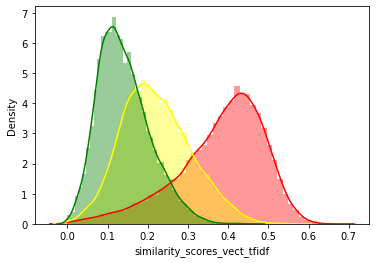

In [20]:
sns.distplot(job_score['similarity_scores_with_stop_words'],color='red')
sns.distplot(job_score['similarity_scores_vect'],color='yellow')
sns.distplot(job_score['similarity_scores_vect_tfidf'],color='green')

In [75]:
##creating the dataframe to store top 10 jobs. 
advertiserurl = []
jobdescription = []
job_scores = []
bag_of_words = []
top_keywords = []
for i in job_score['similarity_scores_vect'].nlargest(n=10).index.to_list():
    advertiserurl.append(data.iloc[i]['advertiserurl'])
    jobdescription.append(data.iloc[i]['jobdescription'])
    job_scores.append(job_score.iloc[i]['similarity_scores_vect'])
    bag_of_words.append(data_clean_stopwords.iloc[i]['jobdescription'])
    #top_keywords.append(data_clean[i]['jobdescription'].split().value_counts()[0:10])

In [77]:
top_10_jobs_list = list(zip(advertiserurl,jobdescription,job_scores,bag_of_words))

In [78]:
top_10_jobs = pd.DataFrame(top_10_jobs_list, columns = ['advertiserurl','jobdescription','job_scores','bag_of_words'])

In [79]:
top_10_jobs

,advertiserurl,jobdescription,job_scores,bag_of_words
0,https://www.dice.com/jobs/detail/Sr.-Web-Devel...,We are currently seeking a senior full stack w...,0.571158,'we currently seeking senior full stack web de...
1,https://www.dice.com/jobs/detail/SDET-%2526%25...,SDET with good Database experienceContract opp...,0.553467,'sdet good database experience contract opport...
2,https://www.dice.com/jobs/detail/Core-Java-Dev...,Synechron on behalf of our leading financial c...,0.542909,'synechron behalf leading financial client loo...
3,https://www.dice.com/jobs/detail/Core-Java-Dev...,Synechron on behalf of our leading financial c...,0.542909,'synechron behalf leading financial client loo...
4,https://www.dice.com/jobs/detail/Core-Java-Dev...,Synechron on behalf of our leading financial c...,0.542909,'synechron behalf leading financial client loo...
5,https://www.dice.com/jobs/detail/Sr-Java-Devel...,Synechron on behalf of our leading financial c...,0.535548,'synechron behalf leading financial client loo...
6,https://www.dice.com/jobs/detail/Senior-Cloud-...,Ossia is looking for a Senior Cloud Engineer t...,0.529041,`` ossia looking senior cloud engineer help ar...
7,https://www.dice.com/jobs/detail/Developer--So...,Sutoer Solutions is looking for a contract Sof...,0.526290,'su er solutions looking contract software dev...
8,https://www.dice.com/jobs/detail/LEAD-Full-Sta...,Lead Full Stack Developers/Senior Software Eng...,0.524375,`` lead full stack developers senior software ...
9,https://www.dice.com/jobs/detail/FullStack-Pyt...,Job Title: Full stack python developerLocation...,0.521704,'job title full stack python developerlocation...


In [76]:
pd.DataFrame(''.join(data_clean_stopwords['jobdescription'][0]).split()).value_counts()

experience          7
skills              6
websphere           6
development         6
strong              5
software            5
testing             5
java                5
build               4
knowledge           4
complex             4
applications        4
proficient          4
hands               3
working             3
teams               3
systems             3
scripting           3
test                3
unix                3
engineering         3
retail              3
soap                3
engineers           2
solutions           2
design              2
sustainability      2
fast                2
delivery            2
selenium            2
services            2
following           2
server              2
frameworks          2
groovy              2
health              2
improve             2
relational          2
lisa                2
problems            2
must                2
networks            2
platforms           2
platform            2
one                 2
databases 

## Using Bert

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
similarity_scores_bert = []
resume = df_resume['resume'].iloc[0]
for i in range(0,len(data_clean1)):
    job_description = data_clean1['jobdescription'].iloc[i]
    text = [resume, job_description]
    encoding = tokenizer.encode(text)
    similarity_scores_bert.append(cosine_similarity(encoding)[0][1])


In [ ]:
## Bert has limitation with a maximun length of 512. 

In [ ]:
from tika import parser
raw = parser.from_file('Yuan Feng, Johana Yi Bin.pdf')
print(raw['content'])

In [ ]:
pip install tika